In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
dataset_url="https://www.kaggle.com/alxmamaev/flowers-recognition"

In [3]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tharunanandmed20b068
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:07<00:00, 30.3MB/s]


In [4]:
data_dir='/content/flowers-recognition/flowers'

In [5]:
import os

In [6]:
os.listdir(data_dir)

['daisy', 'dandelion', 'tulip', 'sunflower', 'rose']

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
dataset=ImageFolder(data_dir)

In [9]:
len(dataset)

4317

In [10]:
for cls in os.listdir(data_dir):
  print(cls,':',len(os.listdir(data_dir+'/'+cls)))

daisy : 764
dandelion : 1052
tulip : 984
sunflower : 733
rose : 784


In [11]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FA0F65430D0>, 0)

In [12]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Visualizing the Dataset


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

0


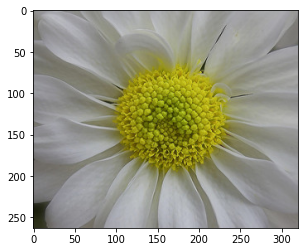

In [14]:
img,label=dataset[0]
plt.imshow(img)
print(label)

In [15]:
import torchvision.transforms as tt

In [16]:
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(64),tt.RandomCrop(64),tt.ToTensor()]))

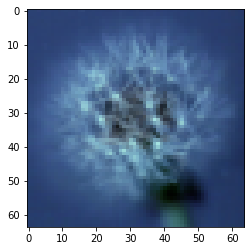

In [17]:
img,label=dataset[900]
plt.imshow(img.permute(1,2,0))

In [18]:
val_pct=0.1
val_size=int(len(dataset)*val_pct)
train_size=len(dataset)-val_size
val_size,train_size

(431, 3886)

In [19]:
from torch.utils.data import random_split
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(3886, 431)

In [20]:
from torch.utils.data import DataLoader

batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


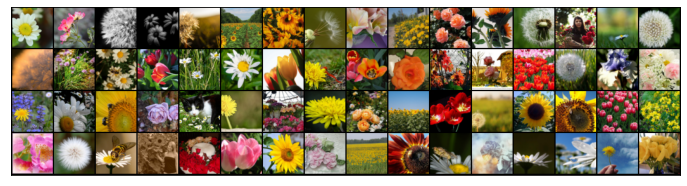

In [22]:
show_batch(train_dl)

GPU Utilities


In [23]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
torch.cuda.is_available()

True

In [25]:
device=get_default_device()

In [26]:
device

device(type='cuda')

In [27]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

Model And Training Utilities


In [28]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input: 256*3*64*64
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [31]:
model = to_device(ResNet9(3, len(dataset.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [32]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tenor through the model

In [33]:
torch.cuda.empty_cache()
for batch in train_dl:
  images,labels=batch
  print('images.shape',images.shape)
  print('images.device',images.device)
  preds=model(images)
  print('preds.shape',preds.shape)
  print(preds)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([64, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([64, 5])
tensor([[ 1.3705,  3.9966,  4.8211, -7.1679,  5.3828],
        [ 1.4835,  1.5488,  3.7412, -3.1081,  2.7792],
        [ 6.4418,  2.0464,  5.6956, -5.5467,  4.3698],
        [ 3.7821,  2.9884,  4.0535, -6.9779,  4.3857],
        [ 2.4033,  0.7491,  3.5062, -2.8663,  2.5735],
        [ 1.3913,  2.1784,  1.3748, -1.5034,  1.4355],
        [ 1.4763,  1.8313,  3.1226, -2.9629,  2.8851],
        [ 1.9331,  2.6869,  5.9422, -3.0140,  5.4910],
        [ 0.7247,  2.1363,  2.7672, -2.1605,  3.1382],
        [ 4.6305,  1.8539,  6.2671, -2.1324,  3.2120],
        [ 1.2742,  3.0979,  2.8917, -2.4122,  1.5361],
        [ 4.0363,  1.1278,  4.1105, -2.0769,  4.5680],
        [ 2.9508,  2.6883,  4.4883, -3.2563,  3.1589],
        [ 3.4449,  2.1633,  3.2499, -5.0052,  4.0250],
        [ 2.0390,  1.4493,  4.9224, -0.9609,  2.2032],
        [ 1.9365,  3.6808,  5.1984, -5.4260,  3.7312],
        [ 2.3731,  4.2910,

Training 

In [34]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.24526262283325195, 'val_loss': 1.6077730655670166}]

In [35]:
history += fit(10,0.001,model,train_dl,valid_dl,torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.2531, val_loss: 1.0452, val_acc: 0.5800
Epoch [1], train_loss: 0.9250, val_loss: 0.9352, val_acc: 0.6537
Epoch [2], train_loss: 0.8311, val_loss: 0.9493, val_acc: 0.6745
Epoch [3], train_loss: 0.7167, val_loss: 0.8460, val_acc: 0.6800
Epoch [4], train_loss: 0.6817, val_loss: 0.7428, val_acc: 0.7263
Epoch [5], train_loss: 0.6128, val_loss: 0.6990, val_acc: 0.7646
Epoch [6], train_loss: 0.5414, val_loss: 0.7722, val_acc: 0.7126
Epoch [7], train_loss: 0.5480, val_loss: 0.8580, val_acc: 0.6951
Epoch [8], train_loss: 0.4997, val_loss: 0.5768, val_acc: 0.7959
Epoch [9], train_loss: 0.4552, val_loss: 0.6025, val_acc: 0.8053


Using Transfer Learning

In [36]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [37]:
model=to_device(ResNet34(len(dataset.classes),pretrained=True),device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [38]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [39]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(img_size),tt.RandomCrop(img_size),tt.ToTensor(),tt.Normalize(*imagenet_stats)]))




In [40]:
from torch.utils.data import random_split
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)
from torch.utils.data import DataLoader

batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [42]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
history=[evaluate(model,valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.15300863981246948, 'val_loss': 1.8846086263656616}]

In [44]:
history+=fit_one_cycle(6,0.001,model,train_dl,valid_dl,weight_decay=0.01,grad_clip=0.1,opt_func=torch.optim.Adam)

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.5346, val_loss: 1.4120, val_acc: 0.7254


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6628, val_loss: 1.9843, val_acc: 0.4686


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5991, val_loss: 0.8911, val_acc: 0.6730


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5000, val_loss: 0.8683, val_acc: 0.6803


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3892, val_loss: 0.3750, val_acc: 0.8665


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2406, val_loss: 0.3278, val_acc: 0.8701
